In [1]:
!pip install --upgrade pip
!pip install pyathena

In [2]:
#Upgrade de la version de seaborn para poder hacer graficos mas facil 
!pip install seaborn==0.12.2

In [3]:
#Libraries
from pyathena import connect
import pandas as pd
import datetime as dt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn import preprocessing
from sklearn.preprocessing import LabelBinarizer 

In [4]:
# DB Setting
bucket_name = 's3://viamericas-datalake-dev-us-east-1-283731589572-athena/'
origin_name = 'AwsDataCatalog'
database_name = 'analytics'
tablaSource = 'source_fraud_fechas_label'


In [5]:
#Connection

conn = connect(s3_staging_dir=f'{bucket_name}queryresults/',
               region_name='us-east-1')
#date_to_compare1 = '2023-01-01'
#date_to_compare2 = '2023-05-01'
#Pongo el mes para el que traigo los datos y para poenr en el nombre del parquet
mes_data = '202304'
#Pongo uno si quiero generar los datos para el test
archivo_test = 0

df_source = pd.read_sql('''SELECT * FROM analytics.source_fraud_fechas_label 
            where date_receiver_clean between cast('2023-04-01'  as date) and cast('2023-04-02'  as date);''', conn)


/tmp/ipykernel_19180/1971959286.py:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_source = pd.read_sql('''SELECT * FROM analytics.source_fraud_fechas_label


In [6]:
#df_source2 = pd.read_sql('''SELECT * FROM analytics.source_fraud_fechas_label 
#             where date_receiver_clean between cast('2023-01-01'  as date) and cast('2023-01-15'  as date);''', conn)


In [7]:
df_source.head()

,id_branch,id_receiver,date_receiver,hour_receiver,day_name_receiver,net_amount_receiver,id_payout,was_fraud,was_fraud_pattern,was_ofac_receiver_hit,...,id_payer,id_sender_global,sender_minutes_since_last_transaction,branch_minutes_since_last_transaction,sender_days_to_last_transaction,day,date_receiver2,id_sender2,fraud_type,date_receiver_clean
0,A17617,71938,2023-04-02 11:55:33.877000000,11,Sunday,51.0,C,0,0,0,...,T068,9884994,0,0,268,2023-04-02,2023-04-02 11:55:33.877,17467.0,None,2023-04-02
1,A21212,9599,2023-04-02 12:09:04.310000000,12,Sunday,100.0,P,0,0,0,...,T228,7359555,5350,5,268,2023-04-02,2023-04-02 12:09:04.310,398.0,None,2023-04-02
2,A01969,329257,2023-04-02 12:10:50.833000000,12,Sunday,1485.0,P,0,0,0,...,T239,8438916,27399,1,268,2023-04-02,2023-04-02 12:10:50.833,24884.0,None,2023-04-02
3,A16174,82267,2023-04-02 12:07:59.133000000,12,Sunday,50.0,P,0,0,0,...,T104,9202334,70374,0,146,2023-04-02,2023-04-02 12:07:59.133,8701.0,None,2023-04-02
4,A23683,4673,2023-04-02 12:01:48.503000000,12,Sunday,1400.0,C,0,0,0,...,T239,9621754,23078,1,259,2023-04-02,2023-04-02 12:01:48.503,809.0,None,2023-04-02


In [8]:
df_source['mes'] = df_source['date_receiver_clean'].dt.month
df_source['fraud_type'] = df_source['fraud_type'].str.capitalize()

## Defino funciones para los datos
### creo_dummies y escalo_percentiles

In [9]:
#defino funcion para normalizar
def escalo_percentiles(data, Pmin, Pmax):
    #Escalo por Quartiles
    Qmin = Pmin
    Qmax = Pmax

    m = data.min()
    M = data.max()
    q0 = data.quantile(Qmin)
    q1 = data.quantile(Qmax)

    data_std = (data - q0) / (q1 - q0)
    dataN =  data_std.to_numpy()
    #Pongo los outliers con un maximo
    dataN = np.clip(dataN,0,1)
    return dataN

In [10]:
#creo dummies a partir de la lista de variables
def creo_dummies(df, todummy_list):
    df0 = df.copy()
    for x in todummy_list:
        dummies = pd.get_dummies(df[x], prefix=x, dummy_na=False)
        df = df.drop(x, axis = 1)
        df = pd.concat([df, dummies], axis=1)
        df = pd.DataFrame(df)
    return df, df.columns.difference(df0.columns)

## Creo las nuevas variables
### sender_days_to_last_transaction_365 y sender_days_to_last_transaction_more365
### sender_minutes_since_last_transaction_2days
### net_amount_receiver?

In [11]:
#defino corte en funcion deñ percenti
df_source['sender_days_to_last_transaction'].describe()

count    182668.000000
mean        203.583633
std          89.386447
min           0.000000
25%         162.000000
50%         252.000000
75%         266.000000
max         274.000000
Name: sender_days_to_last_transaction, dtype: float64

In [12]:
#defino dos nuevas variables a partir de la anterior
df_source['sender_days_to_last_transaction_365'] = df_source['sender_days_to_last_transaction']
df_source['sender_days_to_last_transaction_more365'] = 0
#corto en un maximo de dias y el resto lo pongo enlas variables nuevas
df_source.sender_days_to_last_transaction_more365[df_source['sender_days_to_last_transaction']> 365] = 1
df_source.sender_days_to_last_transaction_365[df_source['sender_days_to_last_transaction']> 365] = 0 

/tmp/ipykernel_19180/461507757.py:5: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_source.sender_days_to_last_transaction_more365[df_source['sender_days_to_last_transaction']> 365] = 1
/tmp/ipykernel_19180/461507757.py:5: SettingWithCopyW

In [13]:
#defino dos nuevas variables a partir de la anterior
df_source['sender_minutes_since_last_transaction_2days'] = df_source['sender_minutes_since_last_transaction']
df_source['sender_minutes_since_last_transaction_1day'] = df_source['sender_minutes_since_last_transaction']
#corto en un maximo de dias y el resto lo pongo enlas variables nuevas
df_source.sender_minutes_since_last_transaction_2days[df_source['sender_minutes_since_last_transaction']> 2*24*60] = 0
df_source.sender_minutes_since_last_transaction_1day[df_source['sender_minutes_since_last_transaction']> 24*60] = 0

/tmp/ipykernel_19180/2804084275.py:5: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_source.sender_minutes_since_last_transaction_2days[df_source['sender_minutes_since_last_transaction']> 2*24*60] = 0
/tmp/ipykernel_19180/2804084275.py:5: 

## Estandarizo variables
### sender_days_to_last_transaction_365, sender_minutes_since_last_transaction_2days, net_amount_receiver, sender_sending_days, branch_working_days, receiver_transaction_count

In [14]:
df_source['receiver_transaction_count'].describe()

count    182668.000000
mean         18.287680
std          22.435802
min           1.000000
25%           3.000000
50%          10.000000
75%          25.000000
max         441.000000
Name: receiver_transaction_count, dtype: float64

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='01_receiver_transaction_count', ylabel='Count'>

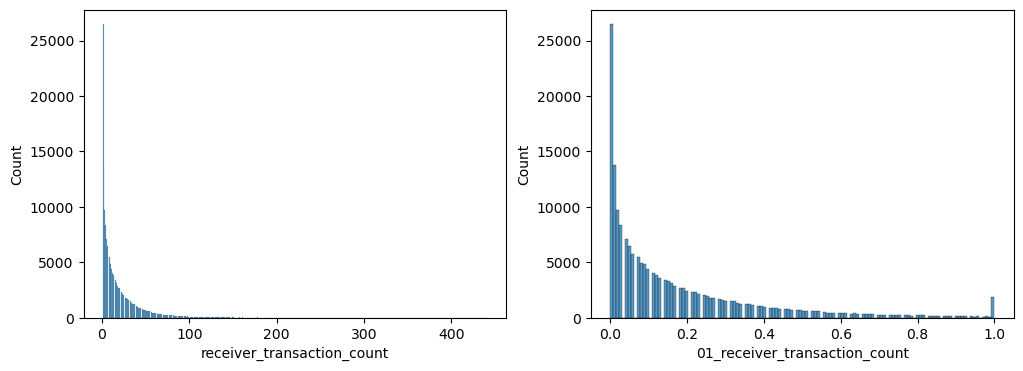

In [15]:
df_source['01_receiver_transaction_count'] = escalo_percentiles(df_source['receiver_transaction_count'], 0.01, 0.99)
fig, axs = plt.subplots(1,2,figsize = (12, 4))
sns.histplot(data=df_source, x="receiver_transaction_count", ax = axs[0])
sns.histplot(data=df_source, x="01_receiver_transaction_count", ax = axs[1])

In [16]:
df_source['sender_sending_days'].describe()

count    182668.000000
mean        273.802270
std         165.075385
min           0.000000
25%         115.000000
50%         322.000000
75%         435.000000
max         456.000000
Name: sender_sending_days, dtype: float64

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='01_sender_sending_days', ylabel='Count'>

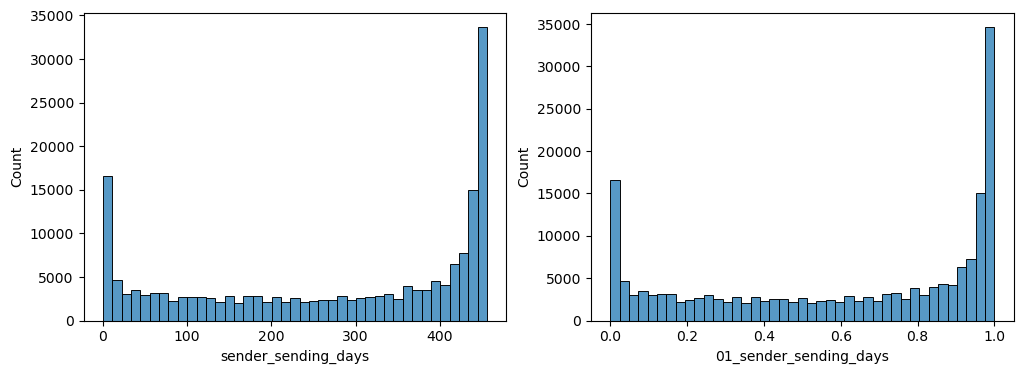

In [17]:
df_source['01_sender_sending_days'] = escalo_percentiles(df_source['sender_sending_days'], 0.01, 0.99)

fig, axs = plt.subplots(1,2,figsize = (12, 4))
sns.histplot(data=df_source, x="sender_sending_days", ax = axs[0])
sns.histplot(data=df_source, x="01_sender_sending_days", ax = axs[1])

In [18]:
df_source['branch_working_days'].describe()

count    182668.000000
mean       1620.592233
std        1433.663946
min           0.000000
25%         571.000000
50%        1143.000000
75%        2272.000000
max        6627.000000
Name: branch_working_days, dtype: float64

In [19]:
df_source['net_amount_receiver'].describe()

count    182668.000000
mean        426.163426
std         529.597770
min           1.000000
25%         100.000000
50%         205.000000
75%         500.000000
max        7990.000000
Name: net_amount_receiver, dtype: float64

In [20]:
df_source['sender_minutes_since_last_transaction_2days'].describe()

count    182668.000000
mean        101.721659
std         431.423402
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max        2880.000000
Name: sender_minutes_since_last_transaction_2days, dtype: float64

In [21]:
df_source['sender_minutes_since_last_transaction_1day'].describe()

count    182668.000000
mean         32.118193
std         188.994324
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max        1440.000000
Name: sender_minutes_since_last_transaction_1day, dtype: float64

In [22]:
df_source['sender_days_to_last_transaction_365'].describe()

count    182668.000000
mean        203.583633
std          89.386447
min           0.000000
25%         162.000000
50%         252.000000
75%         266.000000
max         274.000000
Name: sender_days_to_last_transaction_365, dtype: float64

In [23]:
df_source['branch_minutes_since_last_transaction'].describe()

count    182668.000000
mean         73.083321
std        1139.920563
min           0.000000
25%           2.000000
50%           7.000000
75%          23.000000
max      321234.000000
Name: branch_minutes_since_last_transaction, dtype: float64

In [24]:
# Normalizo a lo bruto. Dsp reviso el algoritmo
df_source['01_receiver_transaction_count'] = escalo_percentiles(df_source['receiver_transaction_count'], 0.01, 0.99)
df_source['01_branch_working_days'] = escalo_percentiles(df_source['branch_working_days'], 0.01, 0.99)
df_source['01_net_amount_receiver'] = escalo_percentiles(df_source['net_amount_receiver'], 0.01, 0.99)
df_source['01_sender_minutes_since_last_transaction_2days'] = escalo_percentiles(df_source['sender_minutes_since_last_transaction'], 0.01, 0.99)
df_source['01_sender_minutes_since_last_transaction_1day'] = escalo_percentiles(df_source['sender_minutes_since_last_transaction'], 0.01, 0.99)
df_source['01_sender_days_to_last_transaction_365'] = escalo_percentiles(df_source['sender_days_to_last_transaction'], 0.01, 0.99)


In [25]:
df_source['01_receiver_transaction_count'].describe()
df_source['01_sender_sending_days'].describe()
df_source['01_branch_working_days'].describe()
df_source['01_net_amount_receiver'].describe()
df_source['01_sender_minutes_since_last_transaction_2days'].describe()
df_source['01_sender_minutes_since_last_transaction_1day'].describe()
df_source['01_sender_days_to_last_transaction_365'].describe()

count    182668.000000
mean          0.743006
std           0.326228
min           0.000000
25%           0.591241
50%           0.919708
75%           0.970803
max           1.000000
Name: 01_sender_days_to_last_transaction_365, dtype: float64

## Creo Variables dummy

In [26]:
todummy_list = ['day_name_receiver','id_payout']
[df_source, var_nuevas] = creo_dummies(df_source, todummy_list)

## Creacion del target

In [27]:
df_source['fraud_type'].value_counts()

Series([], Name: count, dtype: int64)

In [28]:
# defino los targets
df_source['target1'] = df_source['fraud_type'] == 'Remote access'
df_source['target2'] = df_source['fraud_type'] == 'Payment'
df_source['target_fraudes'] = df_source['fraud_type'].notnull()


In [29]:
df_source['target1'].value_counts()

target1
False    182668
Name: count, dtype: int64

In [30]:
df_source['target2'].value_counts()

target2
False    182668
Name: count, dtype: int64

In [31]:
df_source['target_fraudes'].value_counts()

target_fraudes
False    182668
Name: count, dtype: int64

## Guardo archivos para dsp juntar en el entrenamiento

In [37]:
#Me quedo con las variables q voy a usar
df_source.columns.values
df = df_source [[
           '01_receiver_transaction_count','01_sender_sending_days','01_branch_working_days','01_net_amount_receiver','01_sender_minutes_since_last_transaction_2days',
           '01_sender_minutes_since_last_transaction_1day','01_sender_days_to_last_transaction_365']]
df = pd.concat([df, df_source[var_nuevas]], axis=1)
df = pd.concat([df, df_source['target1','target2','target_fraudes']]], axis=1)

##'sender_days_since_last_transaction','sender_minutes_since_last_transaction'
#'id_branch', 'id_receiver', 'hour_receiver','day_name_receiver','net_amount_receiver','was_ofac_receiver_hit','was_ofac_sender_hit',
#'receiver_transaction_count','branch_working_days','sender_sending_days','branch_minutes_since_last_transaction','sender_days_to_last_transaction',
#'fraud_type','date_receiver_clean','target1','target2',

KeyError: ('target1', 'target2', 'target_fraudes')

In [34]:
df

,01_receiver_transaction_count,01_sender_sending_days,01_branch_working_days,01_net_amount_receiver,01_sender_minutes_since_last_transaction_2days,01_sender_minutes_since_last_transaction_1day,01_sender_days_to_last_transaction_365,target1,target2,target_fraudes,...,id_payout_A,id_payout_C,id_payout_D,id_payout_M,id_payout_N,id_payout_O,id_payout_P,id_payout_S,id_payout_T,id_payout_X
0,0.090909,0.000000,0.255265,0.008502,0.000000,0.000000,0.978102,False,False,False,...,False,True,False,False,False,False,False,False,False,False
1,0.010101,1.000000,0.108885,0.028340,0.013577,0.013577,0.978102,False,False,False,...,False,False,False,False,False,False,True,False,False,False
2,0.242424,0.740659,0.977744,0.589069,0.069534,0.069534,0.978102,False,False,False,...,False,False,False,False,False,False,True,False,False,False
3,0.010101,0.356044,0.332991,0.008097,0.178598,0.178598,0.532847,False,False,False,...,False,False,False,False,False,False,True,False,False,False
4,0.080808,0.129670,0.014381,0.554656,0.058568,0.058568,0.945255,False,False,False,...,False,True,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182663,0.242424,0.369231,0.465331,0.036437,0.000005,0.000005,0.985401,False,False,False,...,False,False,False,False,False,False,True,False,False,False
182664,0.414141,0.276923,0.157165,0.089069,0.025381,0.025381,0.996350,False,False,False,...,False,False,False,False,False,False,True,False,False,False
182665,0.020202,0.000000,0.223249,0.089069,0.000000,0.000000,0.109489,False,False,False,...,False,False,False,False,False,False,True,False,False,False
182666,0.090909,0.415385,0.189694,0.016194,0.013283,0.013283,0.992701,False,False,False,...,False,False,False,False,False,False,True,False,False,False


In [ ]:
import os
import pyarrow as pa
import pyarrow.parquet as pq

In [ ]:
#guardar_dataset_con_valor_parquet(df_source, columna_nombre='mes', nombre_archivo='Prepoc_Fraude',carpeta='ABT') # save ABT in parquet format

In [ ]:
if archivo_test == 0:
    s3_url = f"s3://viamericas-datalake-dev-us-east-1-283731589572-raw/FraudModel/Train/Preproc_Fr_{mes_data}.parquet"
elif archivo_test ==1:
    s3_url = f"s3://viamericas-datalake-dev-us-east-1-283731589572-raw/FraudModel/Test/Preproc_Fr_{mes_data}.parquet"
#df.to_parquet(path='./exp1.parquet', engine='pyarrow', compression='gzip')
df.to_parquet(path=s3_url, engine='pyarrow', compression='gzip')
print('termine de salvar el parquet')

## Entreno para probar un minimodelo

In [ ]:
#s3_url = f"s3://viamericas-datalake-dev-us-east-1-283731589572-raw/FraudModel/Train/Preproc_Fr_{mes_data}.parquet"
#df = pd.read_parquet(s3_url)

In [ ]:
df.head(5)

In [ ]:
#features = df[[
#           '01_receiver_transaction_count','01_sender_sending_days','01_branch_working_days','01_net_amount_receiver','01_sender_minutes_since_last_transaction_2days',
#           '01_sender_minutes_since_last_transaction_1day','01_sender_days_to_last_transaction_365',
#           'target_fraudes']]
#label = df['target_fraudes']
#size = 1759577

# Hold out 20% of the dataset for training

#test_size = int(np.round(size * 0.2, 0))# Split dataset into training and testing sets
#x_train = features[:-test_size].values
#y_train = label[:-test_size].values
#x_test = features[-test_size:].values
#y_test = label[-test_size:].values

In [ ]:
#from sklearn import svm

#model = svm.SVC(kernel='poly', degree=2)
#model.fit(x_train, y_train)

In [ ]:
#from sklearn.metrics import accuracy_score
#predictions_poly = model.predict(x_test)
#accuracy_poly = accuracy_score(y_test, predictions_poly)

In [ ]:
#print("2nd degree polynomial Kernel\nAccuracy (normalized): " + str(accuracy_poly))